In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications import MobileNetV2

/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = tf.keras.utils.image_dataset_from_directory(
    './data/raw/Garbage classification/Garbage classification',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2527 files belonging to 6 classes.


In [3]:
ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
CLASS_NAMES = ds.class_names

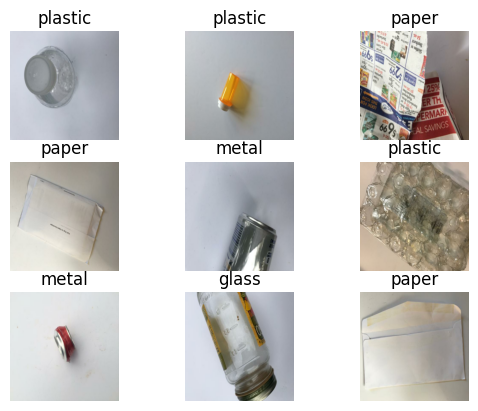

In [5]:
import matplotlib.pyplot as plt

for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [6]:
DATASET_SIZE = 2527 / 32

In [7]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

In [8]:
train_dataset = ds.take(train_size)
rem = ds.skip(train_size)
test_dataset = rem.take(test_size)
val_dataset = rem.skip(test_size)


In [9]:
len(list(test_dataset))

11

In [10]:
NUM_CLASSES = len(CLASS_NAMES)

In [11]:
BATCH_SIZE = 32

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [13]:
base_model_mbnv2 = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
    classes=NUM_CLASSES
)

base_model_mbnv2.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = inputs

x = base_model_mbnv2(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model_mbnv2 = keras.Model(inputs, outputs)

model_mbnv2.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02

In [14]:

import sys
sys.path.insert(0, "../")
from mlflow_emissions_sdk.experiment_tracking_training import EmissionsTrackerMlflow

In [15]:
model_mbnv2.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 1

tracker_info = {
    "tracking_uri": "http://127.0.0.1:5000",
    "experiment_name": "keras_test",
    "run_name": "mobile_net_v2",
    "flavor": "keras"
}

runner = EmissionsTrackerMlflow()
runner.read_params(tracker_info)

runner.start_training_job()

hist = model_mbnv2.fit(train_dataset, epochs=epochs, validation_data=val_dataset, batch_size=32)

runner.end_training_job()
runner.accuracy_per_emission(model_mbnv2, test_dataset)


[codecarbon INFO @ 12:55:28] [setup] RAM Tracking...
[codecarbon INFO @ 12:55:28] [setup] GPU Tracking...
[codecarbon INFO @ 12:55:28] No GPU found.
[codecarbon INFO @ 12:55:28] [setup] CPU Tracking...
[codecarbon WARNING @ 12:55:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 12:55:28] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 12:55:28] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 12:55:28] >>> Tracker's metadata:
[codecarbon INFO @ 12:55:28]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 12:55:28]   Python version: 3.11.6
[codecarbon INFO @ 12:55:28]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 12:55:28]   Available RAM : 16.000 GB
[codecarbon INFO @ 12:55:28]   CPU count: 10
[codecarbon INFO @ 12:55:28]   CPU model: Apple M2 Pro
[codecarbon INFO @ 12:55:28]   GPU count: None
[codecarbon INFO @ 12:55:28]   GPU model: None
2023/10/26 12:55:30 WA

55/55 [==============================] - ETA: 0s - loss: 1.5093 - accuracy: 0.4011

[codecarbon INFO @ 12:55:45] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 12:55:45] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:55:45] 0.000202 kWh of electricity used since the beginning.


1/1 [==============================] - 0s 418ms/step
INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmptqsn2wtc/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmptqsn2wtc/model/data/model/assets
[codecarbon INFO @ 12:56:00] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 12:56:00] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:00] 0.000404 kWh of electricity used since the beginning.
2023/10/26 12:56:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
[codecarbon INFO @ 12:56:08] Energy consumed for RAM : 0.000065 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 12:56:08] Energy consumed for all CPUs : 0.000457 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 12:56:08] 0.000522 kWh of electricity used since the beginning.


11/11 [==============================] - 2s 182ms/step - loss: 1.1880 - accuracy: 0.5568


In [20]:
model_mbnv2.evaluate(ds)

79/79 [==============================] - 14s 174ms/step - loss: 1.1601 - accuracy: 0.5738


[1.1600559949874878, 0.5738029479980469]

In [18]:
type(test_dataset)

tensorflow.python.data.ops.take_op._TakeDataset

In [28]:
if str(type(test_dataset)) == "<class 'tensorflow.python.data.ops.take_op._TakeDataset'>" or str(type(test_dataset)) == "<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>":
    print('lol')

lol


In [26]:
str(type(test_dataset))

"<class 'tensorflow.python.data.ops.take_op._TakeDataset'>"

In [19]:
type(ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [16]:
base_model_resnet50v2 = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
    classes=NUM_CLASSES
)

base_model_resnet50v2.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = inputs

x = base_model_resnet50v2(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model_resnet50v2 = keras.Model(inputs, outputs)

model_resnet50v2.summary()

94668760/94668760 [==============================] - 14s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23577094 (89.94 MB)
Trainable params: 12294 (

In [17]:
model_resnet50v2.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 1

tracker_info = {
    "tracking_uri": "http://127.0.0.1:5000",
    "experiment_name": "keras_test",
    "run_name": "resnet50_v2",
    "flavor": "keras"
}

runner = EmissionsTrackerMlflow()
runner.read_params(tracker_info)

runner.start_training_job()

hist = model_resnet50v2.fit(train_dataset, epochs=epochs, validation_data=val_dataset, batch_size=32)

runner.end_training_job()
runner.accuracy_per_emission(model_resnet50v2, test_dataset)

[codecarbon INFO @ 09:28:25] [setup] RAM Tracking...
[codecarbon INFO @ 09:28:25] [setup] GPU Tracking...
[codecarbon INFO @ 09:28:25] No GPU found.
[codecarbon INFO @ 09:28:25] [setup] CPU Tracking...
[codecarbon WARNING @ 09:28:25] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 09:28:26] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 09:28:26] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 09:28:26] >>> Tracker's metadata:
[codecarbon INFO @ 09:28:26]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 09:28:26]   Python version: 3.11.6
[codecarbon INFO @ 09:28:26]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 09:28:26]   Available RAM : 16.000 GB
[codecarbon INFO @ 09:28:26]   CPU count: 10
[codecarbon INFO @ 09:28:26]   CPU model: Apple M2 Pro
[codecarbon INFO @ 09:28:26]   GPU count: None
[codecarbon INFO @ 09:28:26]   GPU model: None
2023/10/24 09:28:28 WA

16/55 [=======>......................] - ETA: 27s - loss: 110.2747 - accuracy: 0.2148

[codecarbon INFO @ 09:28:43] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:28:43] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:43] 0.000202 kWh of electricity used since the beginning.


37/55 [===================>..........] - ETA: 12s - loss: 88.6826 - accuracy: 0.2255

[codecarbon INFO @ 09:28:58] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:28:58] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:28:58] 0.000404 kWh of electricity used since the beginning.


55/55 [==============================] - ETA: 0s - loss: 80.4437 - accuracy: 0.2301

[codecarbon INFO @ 09:29:13] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:29:13] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:29:13] 0.000606 kWh of electricity used since the beginning.


1/1 [==============================] - 1s 562ms/step


[codecarbon INFO @ 09:29:28] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:29:28] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:29:28] 0.000809 kWh of electricity used since the beginning.


INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpd74i876_/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpd74i876_/model/data/model/assets
[codecarbon INFO @ 09:29:43] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:29:43] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:29:43] 0.001011 kWh of electricity used since the beginning.
[codecarbon INFO @ 09:29:45] Energy consumed for RAM : 0.000128 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 09:29:45] Energy consumed for all CPUs : 0.000909 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 09:29:45] 0.001037 kWh of electricity used since the beginning.


11/11 [==============================] - 9s 735ms/step - loss: 32.5077 - accuracy: 0.3210
